# Лабораторная работа №4 "Классификация в многомерном пространстве"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
np.random.seed(42)

## Постановка задачи

Имеем обучающую выборку в виде векторов многомерного пространства (размерность: 4 - 6). Выборка разделена на 3 непересекающиеся классы. 

Необходимо, на основе обучающей выборки, провести классификацию тестовой выборки тремя разными способами. Способы будут описаны ниже.

## Создание выборок

In [2]:
class ABC_Sample(ABC):
  
    @abstractmethod
    def generate(self, n):
        """
        сгенерировать множество из n точек класса
        """
        pass

In [3]:
class Uniform_Sample(ABC_Sample):
    def __init__(self, limits_list):
        """
        limits_list is list with limits for each dimension
        limits_list = [[min_1, max_1], ..., [min_n, max_n]]
        """
        self.limits_list = np.array(limits_list)
        self.dim = len(limits_list)
    def generate(self,n):
        return np.random.random((n,self.dim)) * \
            (self.limits_list[:,1] - self.limits_list[:,0]) + self.limits_list[:,0]

In [4]:
class Normal_sample(ABC_Sample):
    def __init__ (self, params_list):
        """
        limits_list is list with mean and Standard deviation for each dimension
        limits_list = [[mu_1, sigma_1], ..., [mu_n, sigma_n]]
        """
        self.params_list = np.array(params_list)
        self.dim = len(params_list)
    def generate(self, n):
        return np.hstack([np.random.normal(item[0], item[1],size =  (n,1)) 
                         for item in self.params_list])

Для наглядности протестируем методы для варианта с двухмерной классификацией. Создадим обучающую и тестовую выборку.

Обучающая выборка состоит из точек трех классов. 

- Класс 0. Это равномерное распеделение, его точки лежат внутри $(x,y) \in [3,4) \times [4,5)$;
- Класс 1. Это нормальное распределение, его точки имеют $\mu_x = 1, \sigma_x = 0.1$ по $x$ и $\mu_y = 1, \sigma_y = 0.7$ по $y$;
- Класс 2. Это равномерное распеделение, его точки лежат внутри $(x,y) \in [5,6) \times [0,1)$.

In [5]:
Cl_0 = Uniform_Sample([[3,4], [4,5]])
Cl_1 = Normal_sample([[1,0.1], [1,0.7]])
Cl_2 = Uniform_Sample([[5,6], [0,1]])

In [6]:
dots0 = Cl_0.generate(20)
dots1 = Cl_1.generate(20)
dots2 = Cl_2.generate(20)

In [7]:
X_train = np.concatenate([dots0,dots1,dots2 ])
y_train = np.array([0]*20 + [1]*20 + [2]*20)

In [8]:
testsample = Uniform_Sample([[0,6], [0,5]])
X_test = testsample.generate(100)

Text(0.5, 1.0, 'Before classification')

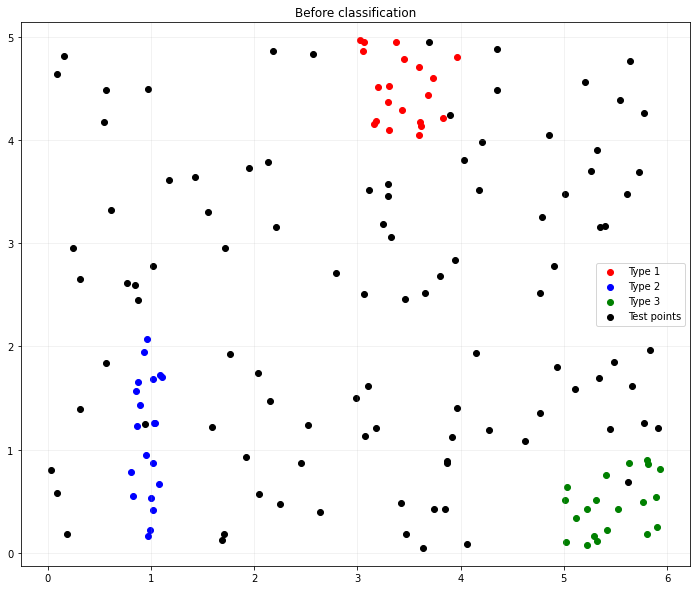

In [9]:
fig = plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'green']
labels = [f'Type {i+1}' for i in range(3)]
dots_list = X_train.reshape(3,20,2)
for index,dots in enumerate(dots_list):
    plt.scatter(dots.T[0], dots.T[1], c = colors[index], label = labels[index])
plt.scatter(X_test.T[0], X_test.T[1], c='black', label = 'Test points')
plt.axis('equal')
plt.grid(alpha=0.2)
plt.legend()
plt.title('Before classification')

## Метод 1

Абстрактный класс

In [10]:
class MyModel (ABC):
    def fit(self,X,y):
        """
        fit model. 
        X - dots. shape (N, dim)
        y - labels. shape (N,)
        """
        self.dim = X.shape[-1]
        
        self.labels = np.unique(y)
        self.means = []
        for i in range(len(self.labels)):
            self.means.append(X[np.where(y == self.labels[i])].sum(axis = 0) /
                             (y == self.labels[i]).sum())
        self.means = np.array(self.means)
    @abstractmethod
    def predict(self,X):
        """
        predicts an unambiguous answer (only 1 class for each point)
        X - the points for which the prediction is made
        """
        pass

### Описание метода

Для классификации используются центры масс классов:
$$
M_k = \frac{ \sum_{j=1}^L \textbf{y}^k_j}{L}
$$
где $M_k$ -- центр масс $k$-го класса. $L$ -- количество элементов(вектров) в классе. $y^k_j$ -- элемент(вектор) $k$-го класса.

Будем классифицировать точки по наиболее значимой разнице до центров масс классов. 

Пусть $M^1, \ldots, M^m$ -- центры масс классов. $X = \left(x_1, \ldots, x_n \right)$ -- точка, которую нужно классифицировать.

Для каждого измерения $i \in \{1, \ldots, n\}$  будем считать расстояние от точки до центров масс классов и считать следующее выражение для каждого класса
$$
    \frac{|M^k_i -x_i|}{ \left(\sum_{j \ne k} |M^j_i - x_i|\right)/(m-1)}
$$
делим расстояние до текущего класса на среднее расстояние до остальных классов. Либо

$$
    \frac{|M^k_i -x_i|}{\min_{j \ne k} |M^j_i - x_i|}
$$
делим расстояние до текущего класса на миимальное расстояние до остальных классов.

В итоге получаем $m \cdot n$ значений (для каждого измерения и каждого класса). Выбираем минимальное значение, и класс, что ему соответствует будет результатом.

In [11]:
class Method_1(MyModel):
    def __init__(self, mean= False):
        self.mean = mean # по умолчанию берется минимум
    def predict(self,X):
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))
        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        
        if self.mean:
            divider = dist_cl.copy()
            for i in range(dist_cl.shape[1]):
                index = list(range(i))+ list(range(i+1, dist_cl.shape[1]))
#                 divider[:,i,:] = (dist_cl.sum(axis = 1)  - dist_cl[:,i,:])/ (dist_cl.shape[1]-1)
                divider[:,i,:] = dist_cl[:,index,:].mean(axis = 1)
        else:
            divider = dist_cl.copy()
            for i in range(dist_cl.shape[1]):
                index = list(range(i))+ list(range(i+1, dist_cl.shape[1]))
                divider[:,i,:] = dist_cl[:,index,:].min(axis = 1)
        
        dist_cl  = dist_cl/divider
        dist_cl = dist_cl.min(axis = -1)
        return np.array([self.labels[i] for i in dist_cl.argmin(axis=-1)])

    def my_predict(self,X):
        """
        возвращает список списков с метками классов. 
        В случае неопределеннойсти вернет список классов, 
        к которым может относится точка.
        """
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))
        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        if self.mean:
            divider = dist_cl.copy()
            for i in range(dist_cl.shape[1]):
                index = list(range(i))+ list(range(i+1, dist_cl.shape[1]))
#                 divider[:,i,:] = (dist_cl.sum(axis = 1)  - dist_cl[:,i,:])/ (dist_cl.shape[1]-1)
                divider[:,i,:] = dist_cl[:,index,:].mean(axis = 1)
        else:
            divider = dist_cl.copy()
            for i in range(dist_cl.shape[1]):
                index = list(range(i))+ list(range(i+1, dist_cl.shape[1]))
                divider[:,i,:] = dist_cl[:,index,:].min(axis = 1)
                
        dist_cl  = dist_cl/divider
        dist_cl = dist_cl.min(axis = -1)
        return [list(self.labels[np.where(dist_cl[i] == dist_cl[i].min())]) for i in range(dist_cl.shape[0])]

### Тесты на плоскости

In [12]:
cls = Method_1()
cls.fit(X_train,y_train)

In [13]:
y_test = cls.predict(X_test)

In [14]:
xx, yy = np.meshgrid(np.linspace(-1,6, 500),np.linspace(-1,6, 500))

z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
Z = z.reshape(xx.shape)

<ipython-input-15-80299d1f1873>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


Text(0.5, 1.0, 'Method 1')

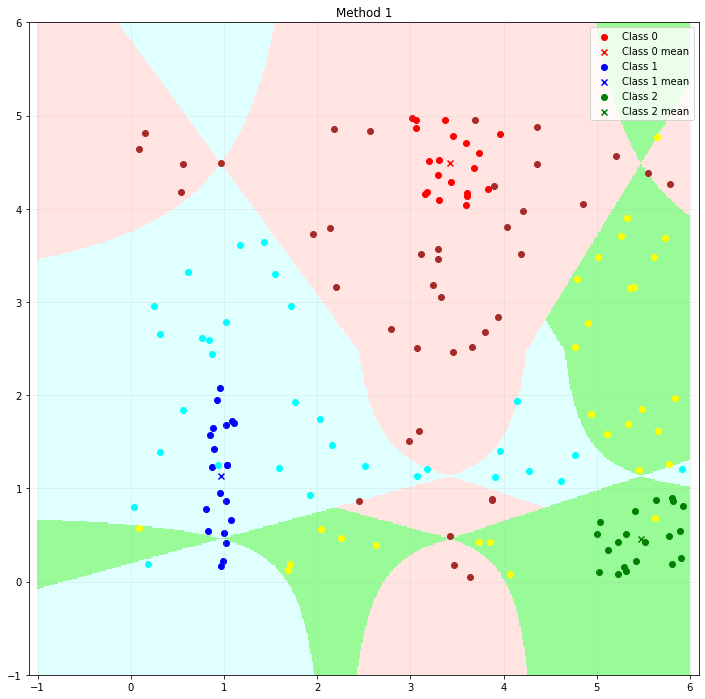

In [15]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
fig = plt.figure(figsize = (12,12))
colors = ['red', 'blue', 'green']
res_colors = ['brown', 'cyan', 'yellow']
labels = [f'Class {i}' for i in range(3)]

cmap_light = ListedColormap(['mistyrose', 'lightcyan', 'palegreen'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

dots_list = X_train.reshape(3,-1,2)
for index,dots in enumerate(dots_list):
    plt.scatter(dots.T[0], dots.T[1], c = colors[index], label = labels[index])
    plt.scatter(cls.means[index][0], cls.means[index][1], marker='x',c= colors[index], label = labels[index]+' mean')
for i in range(len(X_test)):
    plt.scatter(X_test[i][0],X_test[i][1], c= res_colors[y_test[i]])
plt.axis('equal')
plt.grid(alpha=0.2)
plt.legend()
plt.title('Method 1')

Выведем некоторое количество точек для наглядности

In [16]:
n = 10
y_test_cl = cls.my_predict(X_test[:n])
for i in range(n):
    print(f"Dot: {X_test[i]} has class: {y_test_cl[i]}")

Dot: [5.65745822 1.61601466] has class: [2]
Dot: [3.11274373 3.51509479] has class: [0]
Dot: [2.18177761 4.85891041] has class: [0]
Dot: [5.77468377 1.25891148] has class: [2]
Dot: [2.98349104 1.50439155] has class: [0]
Dot: [1.70904297 0.18443474] has class: [2]
Dot: [3.657386   2.51339512] has class: [0]
Dot: [0.30887251 1.39323232] has class: [1]
Dot: [5.44959532 1.19780945] has class: [2]
Dot: [0.86936923 2.4472638 ] has class: [1]


## Метод 2

### Описание метода

Аналогично используются центры масс.

Для класификации выбираем класс, что имеет наименьшее расстояние до точки по наибольшему количеству измерений.

Посчитаем следующую величину
$$
    \left( \text{argmin}_{j \in\{1,\ldots, m\}}|M^j_1 - x_1|, \ldots, \text{argmin}_{j \in \{1,\ldots, m\}}|M^j_n - x_n| \right)
$$

А потом выбираем тот класс, что встечался чаще всего.

In [17]:
from scipy import stats

class Method_2(MyModel):
    def predict(self,X):
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))
        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        
        numbers_cl  = dist_cl.argmin(axis = 1)
        numbers_cl = stats.mode(numbers_cl, axis  = 1)[0].reshape(-1)

        return np.array([self.labels[i] for i in numbers_cl])
    
    def my_predict(self,X):
        """
        возвращает список списков с метками классов. 
        В случае неопределеннойсти вернет список классов, 
        к которым может относится точка.
        """
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))
        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        
        numbers_cl  = dist_cl.argmin(axis = 1)
        
        res = []
                
        for i in range(numbers_cl.shape[0]):
            classes, freq = np.unique(numbers_cl[i], return_counts=True)
            res.append([self.labels[classes[i]] for i in range(len(classes)) if freq[i] == freq.max()])
        return res

### Тесты на плоскости

In [18]:
cls = Method_2()
cls.fit(X_train,y_train)

In [19]:
y_test = cls.predict(X_test)

In [20]:
xx, yy = np.meshgrid(np.linspace(-1,6, 500),np.linspace(-1,6, 500))

z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
Z = z.reshape(xx.shape)

<ipython-input-21-4bdc82806966>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


Text(0.5, 1.0, 'Method 2')

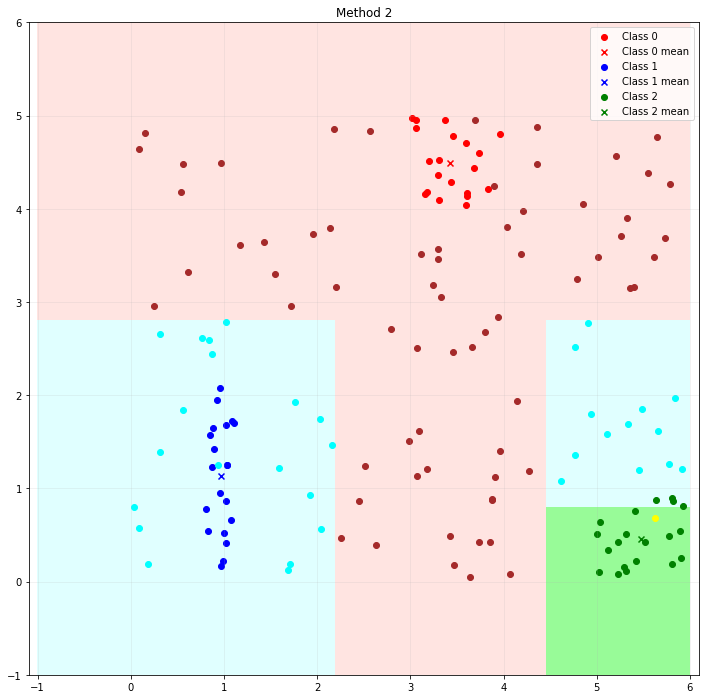

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
fig = plt.figure(figsize = (12,12))
colors = ['red', 'blue', 'green']
res_colors = ['brown', 'cyan', 'yellow']
labels = [f'Class {i}' for i in range(3)]

cmap_light = ListedColormap(['mistyrose', 'lightcyan', 'palegreen'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

dots_list = X_train.reshape(3,-1,2)
for index,dots in enumerate(dots_list):
    plt.scatter(dots.T[0], dots.T[1], c = colors[index], label = labels[index])
    plt.scatter(cls.means[index][0], cls.means[index][1], marker='x',c= colors[index], label = labels[index]+' mean')
for i in range(len(X_test)):
    plt.scatter(X_test[i][0],X_test[i][1], c= res_colors[y_test[i]])
plt.axis('equal')
plt.grid(alpha=0.2)
plt.legend()
plt.title('Method 2')

Выведем некоторое количество точек для наглядности

In [22]:
n = 10
y_test_cl = cls.my_predict(X_test[:n])
for i in range(n):
    print(f"Dot: {X_test[i]} has class: {y_test_cl[i]}")

Dot: [5.65745822 1.61601466] has class: [1, 2]
Dot: [3.11274373 3.51509479] has class: [0]
Dot: [2.18177761 4.85891041] has class: [0, 1]
Dot: [5.77468377 1.25891148] has class: [1, 2]
Dot: [2.98349104 1.50439155] has class: [0, 1]
Dot: [1.70904297 0.18443474] has class: [1, 2]
Dot: [3.657386   2.51339512] has class: [0, 1]
Dot: [0.30887251 1.39323232] has class: [1]
Dot: [5.44959532 1.19780945] has class: [1, 2]
Dot: [0.86936923 2.4472638 ] has class: [1]


## Метод 3

### Описание метода

Аналогично используются центры масс.

Посчитаем сумму расстояний от точки до центров масс классов по каждому измерению. Выберем тот класс, у которого сумма наименьшая.

Выбираем класс по следующему правилу
$$
\text{argmin}_{j \in\{1,\ldots, m\}} \left( \sum_{i=1}^n |M^j_i - x_i| \right)
$$

In [23]:
class Method_3(MyModel):
    def predict(self,X):
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))

        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        dist_cl  = dist_cl.sum(axis = -1)

        return np.array([self.labels[i] for i in dist_cl.argmin(axis=-1)])
    def my_predict(self,X):
        """
        возвращает список списков с метками классов. 
        В случае неопределеннойсти вернет список классов, 
        к которым может относится точка.
        """
        dist_cl = [] # distances to classes
        for mean_cl in self.means:
            dist_cl.append(np.abs(X - mean_cl))

        dist_cl = np.swapaxes(np.array(dist_cl),0,1)
        dist_cl  = dist_cl.sum(axis = -1)

        return [list(self.labels[np.where(dist_cl[i] == dist_cl[i].min())]) for i in range(dist_cl.shape[0])]

### Тесты на плоскости

In [24]:
cls = Method_3()
cls.fit(X_train,y_train)

In [25]:
y_test = cls.predict(X_test)

In [26]:
xx, yy = np.meshgrid(np.linspace(-1,6, 500),np.linspace(-1,6, 500))

z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
Z = z.reshape(xx.shape)

<ipython-input-27-ac6a7701e0f5>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


Text(0.5, 1.0, 'Method 3')

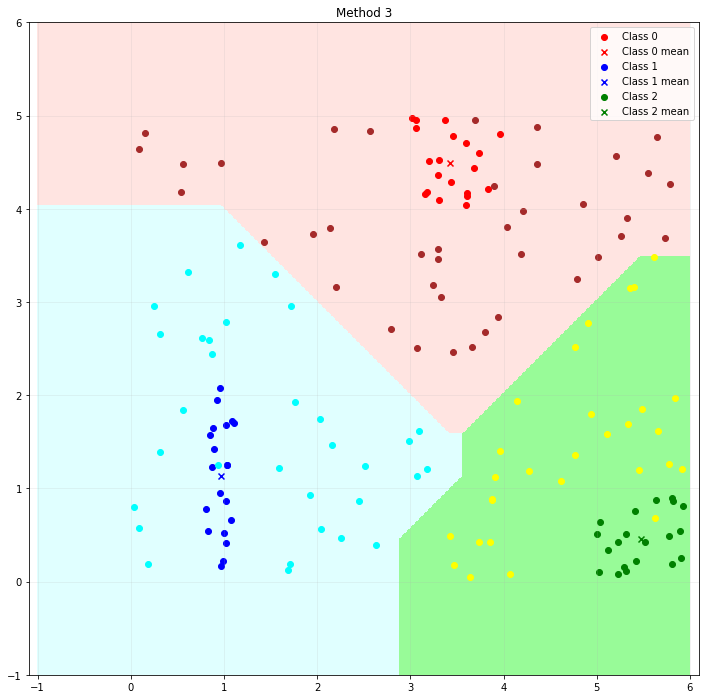

In [27]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
fig = plt.figure(figsize = (12,12))

colors = ['red', 'blue', 'green']
res_colors = ['brown', 'cyan', 'yellow']
labels = [f'Class {i}' for i in range(3)]

cmap_light = ListedColormap(['mistyrose', 'lightcyan', 'palegreen'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

dots_list = X_train.reshape(3,-1,2)
for index,dots in enumerate(dots_list):
    plt.scatter(dots.T[0], dots.T[1], c = colors[index], label = labels[index])
    plt.scatter(cls.means[index][0], cls.means[index][1], marker='x',c= colors[index], label = labels[index]+' mean')
for i in range(len(X_test)):
    plt.scatter(X_test[i][0],X_test[i][1], c= res_colors[y_test[i]])
plt.axis('equal')
plt.grid(alpha=0.2)
plt.legend()
plt.title('Method 3')

Выведем некоторое количество точек для наглядности

In [28]:
n = 10
y_test_cl = cls.my_predict(X_test[:n])
for i in range(n):
    print(f"Dot: {X_test[i]} has class: {y_test_cl[i]}")

Dot: [5.65745822 1.61601466] has class: [2]
Dot: [3.11274373 3.51509479] has class: [0]
Dot: [2.18177761 4.85891041] has class: [0]
Dot: [5.77468377 1.25891148] has class: [2]
Dot: [2.98349104 1.50439155] has class: [1]
Dot: [1.70904297 0.18443474] has class: [1]
Dot: [3.657386   2.51339512] has class: [0]
Dot: [0.30887251 1.39323232] has class: [1]
Dot: [5.44959532 1.19780945] has class: [2]
Dot: [0.86936923 2.4472638 ] has class: [1]


## Многомерная классификация

Для тестов будем использовать датасет **Ирисы Фишера**.

Оценивать точность будем следующим образом (`sklearn` метрика *accuracy*)

$$
\text{accuracy} = \frac{\text{количество верных ответов}}{\text{общее количество точек для классификации}}
$$

In [29]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

In [30]:
iris = load_iris()

### Метод 1 с использованием минимума

In [31]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cls = make_pipeline(StandardScaler(), Method_1())
accuracy = cross_validate(cls, iris.data, iris.target, 
               scoring=['accuracy'], cv = cv)
print('test_accuracy:', np.around(accuracy['test_accuracy'],decimals =3 ))
print('mean accuracy:', round(accuracy['test_accuracy'].mean(), 3))

test_accuracy: [0.867 0.867 0.733 0.9   0.8  ]
mean accuracy: 0.833


### Метод 1 с использованием среднего

In [32]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cls = make_pipeline(StandardScaler(), Method_1(mean =True))
accuracy = cross_validate(cls, iris.data, iris.target, 
               scoring=['accuracy'], cv = cv)
print('test_accuracy:', np.around(accuracy['test_accuracy'],decimals =3 ))
print('mean accuracy:', round(accuracy['test_accuracy'].mean(), 3))

test_accuracy: [0.9   0.867 0.767 0.933 0.833]
mean accuracy: 0.86


### Метод 2

In [33]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cls = make_pipeline(StandardScaler(), Method_2())
accuracy =  cross_validate(cls, iris.data, iris.target, 
               scoring=['accuracy'], cv = cv)
print('test_accuracy:', np.around(accuracy['test_accuracy'],decimals =3 ))
print('mean accuracy:', round(accuracy['test_accuracy'].mean(), 3))

test_accuracy: [0.933 0.9   0.933 0.967 0.833]
mean accuracy: 0.913


### Метод 3

In [34]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cls = make_pipeline(StandardScaler(), Method_3())
accuracy =  cross_validate(cls, iris.data, iris.target, 
                scoring=['accuracy'], cv = cv)
print('test_accuracy:', np.around(accuracy['test_accuracy'],decimals =3 ))
print('mean accuracy:', round(accuracy['test_accuracy'].mean(), 3))

test_accuracy: [0.967 0.9   0.8   0.967 0.8  ]
mean accuracy: 0.887


## Результат

Метод 2 показал себя наилучшим образом на Ирисах Фишера, однако для классификации точек на плоскости этот метод показывает себя плохо (много неопределенных точек). 